In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


Using TensorFlow backend.


In [11]:
from keras.callbacks import TensorBoard
from time import time

In [3]:
train = pd.read_csv("D:/data/movies_reviews/train.tsv", sep="\t")
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
train = train[["Phrase", "Sentiment"]]
train['Phrase'] = train['Phrase'].apply(lambda x: x.lower())

In [5]:
train["Sentiment"].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [6]:
lens = []
for idx, row in train.iterrows():
    lens.append(len(row["Phrase"]))
lens

[188,
 77,
 8,
 1,
 6,
 68,
 2,
 65,
 9,
 55,
 23,
 13,
 9,
 3,
 5,
 31,
 4,
 26,
 4,
 21,
 2,
 18,
 4,
 13,
 3,
 9,
 5,
 110,
 108,
 7,
 4,
 100,
 95,
 91,
 12,
 10,
 6,
 1,
 78,
 13,
 4,
 8,
 5,
 64,
 12,
 51,
 6,
 44,
 3,
 40,
 4,
 35,
 32,
 26,
 7,
 18,
 2,
 15,
 4,
 10,
 7,
 5,
 1,
 74,
 55,
 4,
 50,
 38,
 5,
 32,
 30,
 17,
 13,
 3,
 12,
 11,
 18,
 16,
 8,
 5,
 7,
 100,
 36,
 9,
 4,
 4,
 26,
 23,
 18,
 6,
 11,
 8,
 2,
 4,
 63,
 13,
 11,
 9,
 1,
 7,
 49,
 47,
 5,
 41,
 4,
 36,
 11,
 9,
 4,
 4,
 24,
 7,
 16,
 7,
 8,
 3,
 152,
 150,
 101,
 34,
 32,
 10,
 21,
 9,
 11,
 66,
 63,
 15,
 11,
 47,
 3,
 43,
 39,
 8,
 30,
 28,
 8,
 19,
 17,
 10,
 6,
 6,
 48,
 45,
 26,
 23,
 21,
 13,
 7,
 2,
 18,
 16,
 5,
 10,
 4,
 5,
 60,
 58,
 10,
 47,
 22,
 18,
 24,
 22,
 12,
 9,
 124,
 41,
 14,
 12,
 26,
 23,
 11,
 6,
 4,
 11,
 82,
 80,
 31,
 6,
 24,
 2,
 21,
 19,
 7,
 11,
 48,
 2,
 45,
 19,
 15,
 5,
 9,
 25,
 10,
 14,
 7,
 6,
 52,
 11,
 40,
 38,
 17,
 7,
 9,
 5,
 3,
 20,
 18,
 15,
 13,
 8,
 4,
 112,
 14,

c:\users\nghia\environments\tf-gpu\lib\site-packages\matplotlib\axes\_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0.0, 8890.0)

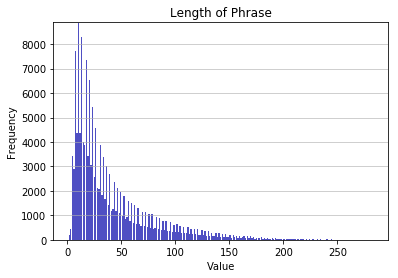

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=lens, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Length of Phrase')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [8]:
max_fatures = 100
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train['Phrase'].values)
X = tokenizer.texts_to_sequences(train['Phrase'].values)
X = pad_sequences(X)
X

array([[ 0,  0,  0, ...,  3,  2, 42],
       [ 0,  0,  0, ..., 46, 13,  1],
       [ 0,  0,  0, ...,  0,  0,  2],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [9]:
X.shape[1]

30

In [22]:
####### BUILD model ##########
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 128)           12800     
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 30, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 985       
Total params: 268,585
Trainable params: 268,585
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
####### convert to 1-hot vector #######
Y = pd.get_dummies(train['Sentiment']).values
Y

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(104560, 30) (104560, 5)
(51500, 30) (51500, 5)


In [23]:
batch_size = 32
tbCallBack = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 30, batch_size=batch_size, verbose = 1, callbacks=[tbCallBack])

Train on 104560 samples, validate on 51500 samples
Epoch 1/30
104560/104560 [==============================] - 296s 3ms/step - loss: 1.2025 - acc: 0.5293 - val_loss: 1.1902 - val_acc: 0.5315
Epoch 2/30
104560/104560 [==============================] - 286s 3ms/step - loss: 1.1811 - acc: 0.5360 - val_loss: 1.1820 - val_acc: 0.5361
Epoch 3/30
104560/104560 [==============================] - 286s 3ms/step - loss: 1.1735 - acc: 0.5402 - val_loss: 1.1783 - val_acc: 0.5370
Epoch 4/30
104560/104560 [==============================] - 276s 3ms/step - loss: 1.1681 - acc: 0.5425 - val_loss: 1.1770 - val_acc: 0.5379
Epoch 5/30
104560/104560 [==============================] - 275s 3ms/step - loss: 1.1626 - acc: 0.5451 - val_loss: 1.1692 - val_acc: 0.5401
Epoch 6/30
104560/104560 [==============================] - 280s 3ms/step - loss: 1.1557 - acc: 0.5485 - val_loss: 1.1662 - val_acc: 0.5436
Epoch 7/30
104560/104560 [==============================] - 277s 3ms/step - loss: 1.1484 - acc: 0.5524 - val_

In [24]:
model.save('models/LSTM_30epochs_0511.h5')

In [25]:
test = pd.read_csv("D:\data\movies_reviews\\test.tsv", sep="\t")
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [27]:
test = test[["PhraseId", "Phrase"]]
test['Phrase'] = test['Phrase'].apply(lambda x: x.lower())
test.head()

,PhraseId,Phrase
0,156061,an intermittently pleasing but mostly routine ...
1,156062,an intermittently pleasing but mostly routine ...
2,156063,an
3,156064,intermittently pleasing but mostly routine effort
4,156065,intermittently pleasing but mostly routine


In [28]:
X_test = tokenizer.texts_to_sequences(test['Phrase'].values)
X_test = pad_sequences(X_test, maxlen=X.shape[1])

In [29]:
X_test.shape

(66292, 30)

In [37]:
result = model.predict(X_test, batch_size=32, verbose=1)

66292/66292 [==============================] - 62s 928us/step


In [38]:
result

array([[0.00690174, 0.2014602 , 0.5233483 , 0.259251  , 0.00903881],
       [0.00690174, 0.2014602 , 0.5233483 , 0.259251  , 0.00903881],
       [0.02916227, 0.12586157, 0.46928945, 0.29753608, 0.07815056],
       ...,
       [0.02117437, 0.12293683, 0.5814081 , 0.22314556, 0.05133512],
       [0.02117437, 0.12293683, 0.5814081 , 0.22314556, 0.05133512],
       [0.01903232, 0.13109483, 0.66615635, 0.15762158, 0.02609488]],
      dtype=float32)

In [39]:
predictions = [np.argmax(line) for line in result]
predictions

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [40]:
res = pd.DataFrame({"PhraseId": test["PhraseId"], "Sentiment": predictions})

In [41]:
res.to_csv("submission.csv", index=False)

In [36]:
from keras.models import load_model
model = load_model('models/model_7epochs.h5')

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(104560, 30) (104560, 5)
(51500, 30) (51500, 5)


In [44]:
pred_val = model.predict(X_val, batch_size=32, verbose=1)

51500/51500 [==============================] - 45s 882us/step


In [52]:
predictions_val = [np.argmax(line) for line in pred_val]
target = [np.argmax(line) for line in Y_val]

In [54]:
print(confusion_matrix(target, predictions_val))

[[  205   511  1352   258    15]
 [  206  1709  6503   622    21]
 [   78  1035 23732  1112    41]
 [   32   499  8133  2163   163]
 [   12   111  1800   942   245]]


In [51]:
predictions_val

[2,
 3,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 3,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 0,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 1,
 2,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
